# Exploration strategies for DQN algorithm

In this assignment we are interested in exploration strategies that can be combined with Q-learning.
Q-learning is an off-policy algorithm, which means that the data for the algorithm can be collected by a different policy (called behavioural policy) that the one the algorithm learns.

Here we come across a classical trade-off in reinforcement learning, called exploration-exploitation trade-off. On the one hand, our behavioural policy should try out new state-action pairs to gain knowledge about their returns. On the other hand, when our estimate of returns is good enough, we would like to follow the state-action pairs with the highest estimated returns.

We will be operating on DQN [(Mnih 2014)](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) algorithm and analyzing epsilon-greedy strategy, boltzmann and max-boltzmann strategy and combination of epsilon-greedy and boltzmann.
We evaluate performance of DQN variants on the Lunar Lander environment.

We provide an implementation of the DQN algorithm with random exploration strategy.
Your goal is to implement the exploration variants by overriding appropriate methods of the provided class.


## Grading

To obtain the points for the assignment You need to provide the implementation of exploration techniques AND report with plots and conclusions.
Measuring sensitivity means that You should at least examine one reasonably lower and one reasonably greater value of the considered hyperparameter (or the pair of hyperparameters).


1. Implement epsilon-greedy strategy and investigate hyperparameter sensitivity (1 point).
2. Implement epsilon-greedy strategy with epsilon annealing and investigate hyperparameter sensitivity (1 point).
3. Implement boltzmann strategy and investigate hyperparameter sensitivity (1 point).
4. Implement boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
5. Implement max-boltzmann strategy and investigate hyperparameter sensitivity (1 point).
6. Implement max-boltzmann strategy with temperature annealing and investigate hyperparameter sensitivity (1 point).
7. Implement combination of epsilon-greedy with epsilon annealing and boltzmann strategy and investigate hyperparameter sensitivity (1 point)
8. (*) Bonus: propose another reasonable approach to combine epsilon-greedy with epsilon annealing strategy and boltzmann strategy and/or another reasonable strategy of temperature annealing for the boltzmann strategy (2 points).
9. Compare methods, present plots and conclusions in a clear manner (3 points).

You can obtain max 10 points, bonus points increase Your score, if You lose points in some other tasks.

Here we import necessary libraries.

In [ ]:
!apt-get install swig
!pip install gymnasium[box2d]

In [2]:
import torch
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

Here we set hyperparameters of the training, set seeds for reproducibility and set weights initialization.
Although for debugging it might be useful to operate on a smaller number of training_steps, seeds etc., in the final evaluation DO NOT CHANGE these parameters.

In [3]:
class parse_args:
  def __init__(self):
    self.n_seeds = 6
    self.n_evaluate_episodes = 5
    self.n_training_steps = 100000
    self.buffer_size = 10000
    self.init_steps = 10000
    self.target_update_freq = 50
    self.eval_freq = 1000
    self.gym_id = "LunarLander-v3"
    env = gym.make(self.gym_id)
    self.state_dim = env.observation_space.shape[0]
    self.batch_size = 128
    self.hidden_dim = 128
    self.action_dim = env.action_space.n
    self.discount = 0.99
    self.lr = 7e-4
    self.cuda = True
    self.device = torch.device("cuda" if torch.cuda.is_available() and self.cuda else "cpu")

args = parse_args()
first_half_training_args = parse_args()
first_half_training_args.n_training_steps = first_half_training_args.n_training_steps // 2
second_half_training_args = parse_args()
second_half_training_args.n_training_steps = second_half_training_args.n_training_steps // 2
second_half_training_args.init_steps = 1

/home/piotrbaranowski/.venvs/jupyter2/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [4]:
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)

def weight_init(model):
  torch.nn.init.orthogonal_(model.weight.data)
  model.bias.data.fill_(0.0)

Here we implement the replay buffer.
It has two methods: add one transition to the buffer and sample batch of transitions from the buffer.

In [5]:
class ReplayBuffer:
  def __init__(self, args):
    self.states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.actions = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.rewards = np.zeros((args.buffer_size, args.n_seeds), dtype = np.float32)
    self.next_states = np.zeros((args.buffer_size, args.n_seeds, args.state_dim), dtype = np.float32)
    self.terminals = np.zeros((args.buffer_size, args.n_seeds), dtype = np.int64)
    self.idx = 0
    self.current_size = 0
    self.args = args

  def add(self, state, action, reward, next_state, terminal):
    if self.current_size < self.args.buffer_size:
      self.current_size += 1
    self.states[self.idx, :, :] = state
    self.actions[self.idx, :] = action
    self.rewards[self.idx, :] = reward
    self.next_states[self.idx, :, :] = next_state
    self.terminals[self.idx, :] = terminal
    self.idx = (self.idx + 1) % self.args.buffer_size

  def sample(self):
    sample_idxs = np.random.permutation(self.current_size)[:self.args.batch_size]
    states = torch.from_numpy(self.states[sample_idxs]).to(self.args.device)
    actions = torch.from_numpy(self.actions[sample_idxs]).to(self.args.device)
    rewards = torch.from_numpy(self.rewards[sample_idxs]).to(self.args.device)
    next_states = torch.from_numpy(self.next_states[sample_idxs]).to(self.args.device)
    terminals = torch.from_numpy(self.terminals[sample_idxs]).to(self.args.device)

    return states, actions, rewards, next_states, terminals


Here we implement a simple Q network architecture with three layers and ReLU activations.

In [6]:
class QNetwork(torch.nn.Module):
  def __init__(self, args):
    super(QNetwork, self).__init__()
    self.layer_1 = torch.nn.Linear(args.state_dim, args.hidden_dim)
    self.layer_2 = torch.nn.Linear(args.hidden_dim, args.hidden_dim)
    self.layer_3 = torch.nn.Linear(args.hidden_dim, args.action_dim)
    self.relu = torch.nn.ReLU()

    self.layer_1.apply(weight_init)
    self.layer_2.apply(weight_init)
    self.layer_3.apply(weight_init)

  def forward(self, x):
    x = self.relu(self.layer_1(x))
    x = self.relu(self.layer_2(x))
    x = self.layer_3(x)

    return x

Here we provide code for DQN with random exploration.

In [7]:
TRAIN_SEED = 0
EVAL_SEED = 1

class DQN:
  def __init__(self, args):
    self.args = args
    self.discount = self.args.discount
    self.reset()
    self.annealing = False

  # Copying parameters of other DQN class by reference (for half epsion-greedy, half boltzmann task)
  def copy_reference(self, other):
    self.buffer = other.buffer
    self.q_net = other.q_net
    self.q_target = other.q_target
    self.optimizer = other.optimizer

  # Annealing of epsilon and/or temperature
  def anneal(self, step):
    pass

  # Greedy action
  def get_greedy_action(self, states):
    with torch.no_grad():
      action = torch.argmax(self.q_net(states), dim = -1).detach().cpu().numpy()
      return action

  # Exploration action choice
  def explore(self, states):
    # Random action choice
    action = np.random.randint(self.args.action_dim, size = self.args.n_seeds)
    return action

  # Update of the main critic
  def update(self):
    states, actions, rewards, next_states, terminals = self.buffer.sample()
    with torch.no_grad():
      q_next_states = torch.max(self.q_target(next_states), dim = -1)[0]
    ones_tensor = torch.ones_like(terminals).to(self.args.device)
    targets = rewards + (ones_tensor - terminals) * self.discount * q_next_states

    self.optimizer.zero_grad()
    q_values = self.q_net(states).gather(-1, actions.unsqueeze(-1)).squeeze(-1)
    loss = torch.mean((q_values - targets) ** 2)
    loss.backward()
    self.optimizer.step()

  # Update of the targer critic
  def update_target(self):
    self.q_target.load_state_dict(self.q_net.state_dict())

  # Evaluation of the performance on test environments.
  def evaluate(self):
    eval_results = np.zeros(self.args.n_seeds)
    with torch.no_grad():
      eval_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
      eval_env.reset(seed = EVAL_SEED)
      for _ in range(self.args.n_evaluate_episodes):
        state, info = eval_env.reset()
        episode_reward = np.zeros(self.args.n_seeds)
        mask = np.ones(self.args.n_seeds)
        while np.sum(mask) > 0:
          action = self.get_greedy_action(torch.tensor(state).to(self.args.device))
          next_state, reward, terminal, truncated, _ = eval_env.step(action)
          episode_reward += mask * reward
          state = next_state
          mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
        eval_results += episode_reward / self.args.n_evaluate_episodes
    return np.mean(eval_results), np.std(eval_results)


  # Resetting the algorithm
  def reset(self):
    self.buffer = ReplayBuffer(self.args)
    self.q_net = QNetwork(self.args).to(self.args.device) # main critic
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = self.args.lr, eps = 1e-5)
    self.q_target = QNetwork(self.args).to(self.args.device) # target critic
    self.update_target()

  # Training loop
  def train(self):
    eval_results_means = np.array([])
    eval_results_stds = np.array([])
    train_env = gym.make_vec(self.args.gym_id, num_envs = self.args.n_seeds, vectorization_mode="sync")
    state, info = train_env.reset(seed = TRAIN_SEED)
    mask = np.ones(self.args.n_seeds)
    for step in range(self.args.n_training_steps):
      action = self.explore(torch.tensor(state).unsqueeze(0).to(self.args.device))
      if self.annealing:
        self.anneal(step)
      next_state, reward, terminal, truncated, _ = train_env.step(action)
      self.buffer.add(state, action, reward, next_state, terminal)
      state = next_state
      if step % self.args.eval_freq == 0:
          print(f"Training step: {step}")
          eval_mean, eval_std = self.evaluate()
          print(f"Eval mean: {eval_mean}; eval_std: {eval_std}")
          eval_results_means = np.append(eval_results_means, eval_mean)
          eval_results_stds = np.append(eval_results_stds, eval_std)
      if step >= self.args.init_steps:
        self.update()
        if step % self.args.target_update_freq == 0:
          self.update_target()
      mask *= (np.ones(self.args.n_seeds) - terminal) * (np.ones(self.args.n_seeds) - truncated)
      if np.sum(mask) == 0:
        state, info = train_env.reset()
        mask = np.ones(self.args.n_seeds)

    return eval_results_means, eval_results_stds


Here we implement functions for plotting.

In [8]:
def smooth(data, weigth = 0.9):
  smooth_data = np.copy(data)
  for index in range(1, len(data)):
    smooth_data[index] = smooth_data[index - 1] * weigth + data[index] * (1.0 - weigth)

  return smooth_data

def plot_smooth(args, result_means, result_stds):
  smooth_result_means = smooth(result_means)
  smooth_result_stds = smooth(result_stds)
  print(smooth_result_means)
  print(smooth_result_stds)
  xs = np.arange(len(result_means)) * args.eval_freq
  print(xs)
  plt.plot(xs, smooth_result_means, color = "blue")
  plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, label = "smoothed_rewards")
  plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_smooth_many(args, result_means_list, result_stds_list, names_list, colours_list):
  plt.figure(figsize=(12.8, 9.6))
  for result_means, result_stds, name, colour in zip(result_means_list, result_stds_list, names_list, colours_list):
    smooth_result_means = smooth(result_means)
    smooth_result_stds = smooth(result_stds)
    print(smooth_result_means)
    print(smooth_result_stds)
    xs = np.arange(len(result_means)) * args.eval_freq
    print(xs)
    plt.plot(xs, smooth_result_means, color = colour)
    plt.fill_between(xs, smooth_result_means - smooth_result_stds, smooth_result_means + smooth_result_stds, alpha = 0.2, color = colour, label = f"smoothed_rewards_{name}")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
  plt.show()
  plt.clf()

def plot_results(result_mean, result_std):
  plot_smooth(args, result_mean, result_std)

def plot_results_many(result_means_list, result_stds_list, name_list, colours_list):
  plot_smooth_many(args, result_means_list, result_stds_list, name_list, colours_list)

Here we provide code for training across different random seeds.

In [9]:
def train_dqn(dqn):
  set_seed(TRAIN_SEED)
  dqn.reset()
  result_mean, result_std = dqn.train()
  print(result_mean)
  return result_mean, result_std


In [ ]:
dqn = DQN(args)
result_means_dqn, result_stds_dqn = train_dqn(dqn)
plot_results(result_means_dqn, result_stds_dqn)

Here the goal is to implement the epsilon-gredy strategy. With probability epsilon we choose uniformly a random action and with probability 1-epsilon we take the action with the highest Q-value according to the main critic.

In [11]:
class EpsilonGreedyDQN(DQN):
  def __init__(self, args):
    super(EpsilonGreedyDQN, self).__init__(args)
    self.epsilon = 0.1 # investigate sensitivity

  def explore(self, states):
  
    explore_mask = np.random.rand(self.args.n_seeds) < self.epsilon

    with torch.no_grad():
      greedy_actions = torch.argmax(self.q_net(states), dim=-1).detach().cpu().numpy().squeeze(0)
    
    random_actions = np.random.randint(self.args.action_dim, size=self.args.n_seeds)

    action = np.where(explore_mask, random_actions, greedy_actions)

    return action

In [ ]:
epsilon_greedy_dqn = EpsilonGreedyDQN(args)
result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn = train_dqn(epsilon_greedy_dqn)
plot_results(result_means_epsilon_greedy_dqn, result_stds_epsilon_greedy_dqn)

Here we add to the epsilon-greedy strategy epsilon annealing. We change linearly epsilon from 1.0 to the value final_epsilon during first anneal_steps steps and then it remains on the final_epsilon level.
Such an approach aims to increase the exploration level at the beginning of the training, when the Q-value estimate is poor and thus choosing greedily according to Q is not improving the performance.

In [13]:
class EpsilonGreedyWithAnnealingDQN(EpsilonGreedyDQN):
  def __init__(self, args):
    self.start_epsilon = 1.0
    super(EpsilonGreedyWithAnnealingDQN, self).__init__(args)
    self.epsilon = self.start_epsilon
    self.final_epsilon = 0.1 # investigate sensitivity
    self.annealing = True
    self.anneal_steps = 30000

  def anneal(self, step):
    f = step / self.anneal_steps
    self.epsilon = self.start_epsilon - f * (self.start_epsilon - self.final_epsilon)
    self.epsilon = max(self.epsilon, self.final_epsilon)

  def reset(self):
    super(EpsilonGreedyWithAnnealingDQN, self).reset()
    self.epsilon = self.start_epsilon

In [ ]:
epsilon_greedy_with_annealing_dqn = EpsilonGreedyWithAnnealingDQN(args)
result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn = train_dqn(epsilon_greedy_with_annealing_dqn)
plot_results(result_means_epsilon_greedy_with_annealing_dqn, result_stds_epsilon_greedy_with_annealing_dqn)

Alternative approach to the epsilon-greedy strategy is to use so-called boltzmann exploration strategy.
The idea behind this approach is to perform softmax on the Q-values coming from the main critic and then sample from the obtained distribution.
In this approach we use softmax with a temperature, i.e. before applying softmax, we scale all the Q-values by the temperature coefficient (in the literature we usually divide by the temperature, but this is equivallent to scaling by the inverse of the temperature). Large scaling values make the distribution close to the greedy choice, while low scaling values make the distribution close to the uniform one.

In [15]:
class BoltzmannDQN(DQN):
  def __init__(self, args):
    super(BoltzmannDQN, self).__init__(args)
    self.temperature = 1.0 # investigate sensitivity

  def explore(self, states):

    with torch.no_grad():
      q = self.q_net(states).squeeze(0)
      probs = torch.softmax(self.temperature * q, dim=-1)
      action = torch.multinomial(probs, num_samples=1).squeeze(-1).cpu().numpy()

    return action


In [ ]:

boltzmann_dqn = BoltzmannDQN(args)
result_means_boltzmann_dqn, result_stds_boltzmann_dqn = train_dqn(boltzmann_dqn)
plot_results(result_means_boltzmann_dqn, result_stds_boltzmann_dqn)

One of the compromises between epsilon-greedy and boltzmann exploration strategy is so-calles max-boltzmann strategy. In this strategy with probability 1-epsilon we choose action greedily, but with probability epsilon we perform the boltzmann choice instead of the uniform random choice.

In [17]:
class MaxBoltzmannDQN(EpsilonGreedyWithAnnealingDQN):
  def __init__(self, args):
    super(MaxBoltzmannDQN, self).__init__(args)
    self.temperature = 0.1 # investigate sensitivity

  def explore(self, states):
    action = None
    with torch.no_grad():
      explore_mask = np.random.rand(self.args.n_seeds) < self.epsilon

      q = self.q_net(states).squeeze(0)

      greedy_action = torch.argmax(q, dim=-1).detach().cpu().numpy()

      probs = torch.softmax(self.temperature * q, dim=-1)
      boltzmann_action = torch.multinomial(probs, num_samples=1).squeeze(-1).detach().cpu().numpy()

      action = np.where(explore_mask, boltzmann_action, greedy_action)

    return action

In [ ]:
max_boltzmann_dqn = MaxBoltzmannDQN(args)
result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn = train_dqn(max_boltzmann_dqn)
plot_results(result_means_max_boltzmann_dqn, result_stds_max_boltzmann_dqn)

Similarly to adjusting the value of epsilon in epsilon-greedy strategy, we can adjust the temperature in the max-boltzmann and boltzmann strategies: we start we the value start_temperature and linearly increase the value to the final_temperature during temperature_anneal_steps, then the temperature is on the constant level.


In [19]:
class MaxBoltzmannWithTemperatureAnnealingDQN(MaxBoltzmannDQN):
  def __init__(self, args):
    self.start_temparature = 0.025 # investigate sensitivity
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temparature
    self.final_temperature = 0.3 # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).anneal(step)
    f = min(step / self.temperature_anneal_steps, 1.0)
    self.temperature = self.start_temparature + f * (self.final_temperature - self.start_temparature)


  def reset(self):
    super(MaxBoltzmannWithTemperatureAnnealingDQN, self).reset()
    self.temperature = self.start_temparature

In [ ]:
max_boltzmann_temp_anneal_dqn = MaxBoltzmannWithTemperatureAnnealingDQN(args)
result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn = train_dqn(max_boltzmann_temp_anneal_dqn)
plot_results(result_means_max_boltzmann_temp_anneal_dqn, result_stds_max_boltzmann_temp_anneal_dqn)

In [21]:
class BoltzmannWithTemperatureAnnealingDQN(BoltzmannDQN):
  def __init__(self, args):
    self.start_temparature = 0.25 # investigate sensitivity
    super(BoltzmannWithTemperatureAnnealingDQN, self).__init__(args)
    self.temperature = self.start_temparature
    self.final_temperature = 3.0 # investigate sensitivity
    self.temperature_anneal_steps = 30000
    self.annealing = True

  def anneal(self, step):
    f = min(step / self.temperature_anneal_steps, 1.0)
    self.temperature = self.start_temparature + f * (self.final_temperature - self.start_temparature)

  def reset(self):
    super(BoltzmannWithTemperatureAnnealingDQN, self).reset()
    self.temperature = self.start_temparature

In [ ]:
boltzmann_temp_anneal_dqn = BoltzmannWithTemperatureAnnealingDQN(args)
result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn = train_dqn(boltzmann_temp_anneal_dqn)
plot_results(result_means_boltzmann_temp_anneal_dqn, result_stds_boltzmann_temp_anneal_dqn)

The last exploration idea we want to implement is a combintation of the epsilon-greedy strategy (with epsilon annealing) and the boltzmann strategy.
We could think that at the beginning of the training the boltzmann strategy struggles because the Q-function (the main critic) is not yet well-trained. However, the more critic is trained, the more sense it makes to start using the boltzmann strategy. We would like to verif y this hypoothesis by using in the first half of the training epsilon-greedy strategy (with epsilon annealing) and in the second half of the training switch the exploration strategy to the boltzmann one.

In [23]:
def train_two_halfs_dqn(dqn_1, dqn_2):
  set_seed(TRAIN_SEED)

  result_mean1, result_std1 = train_dqn(dqn_1)
  dqn_2.copy_reference(dqn_1)
  result_mean2, result_std2 = dqn_2.train()

  result_mean = np.concatenate([result_mean1, result_mean2])
  result_std = np.concatenate([result_std1, result_std2])
  return result_mean, result_std

In [ ]:
epsilon_greedy_with_annealing_half_dqn = EpsilonGreedyWithAnnealingDQN(first_half_training_args) # investigate sensitivity of epsilon
epsilon_greedy_boltzmann_half_dqn = BoltzmannDQN(second_half_training_args) # investigate sensitivity of temperature
result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn, result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn = train_two_halfs_dqn(epsilon_greedy_with_annealing_half_dqn, epsilon_greedy_boltzmann_half_dqn)
plot_results(result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn, result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn)

Here we plot the results of all exploration methods on one plot. However, for drawing conclusions, it might be reasonable to plot some subsets of methods together, for example to compare variants with and without annealing, max-boltzmann with boltzmann, epsilon-greedy, boltzmann and half-epsilon-greedy, half-boltzmann.

In [ ]:
result_means_list = [result_means_dqn, result_means_epsilon_greedy_dqn, result_means_epsilon_greedy_with_annealing_dqn,
                result_means_boltzmann_dqn, result_means_boltzmann_temp_anneal_dqn,
                result_means_max_boltzmann_dqn, result_means_max_boltzmann_temp_anneal_dqn,
                result_means_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
result_stds_list = [result_stds_dqn, result_stds_epsilon_greedy_dqn, result_stds_epsilon_greedy_with_annealing_dqn,
                result_stds_boltzmann_dqn, result_stds_boltzmann_temp_anneal_dqn,
                result_stds_max_boltzmann_dqn, result_stds_max_boltzmann_temp_anneal_dqn,
                result_stds_epsilon_greedy_with_annealing_half_epsilon_greedy_boltzmann_half_dqn]
names_list = ["random", "epsilon-greedy", "epsilon-greedy-with-annealing",
             "boltzmann", "boltzmann-with-annealing",
             "max-boltzmann", "max-boltzmann-with-annealing",
             "half-epsilon-greedy-with-annealing_half-boltzmann"]
colours_list = ["red", "green", "blue",
           "yellow", "magenta",
           "cyan", "black",
           "orange"]

plot_results_many(result_means_list, result_stds_list, names_list, colours_list)

In [26]:
import os
import re
import json
from datetime import datetime

In [27]:
def _safe_name(name: str) -> str:
    name = name.strip().lower()
    name = re.sub(r"\s+", "_", name)
    name = re.sub(r"[^a-z0-9_\-\.=->]", "", name)
    return name[:180]

import numpy as np
import torch

def _jsonify(x):
    if x is None:
        return None
    if isinstance(x, (str, bool, int, float)):
        return x
    if isinstance(x, (np.integer, np.floating)):
        return x.item()
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, torch.device):
        return str(x)
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().tolist()
    if isinstance(x, dict):
        return {str(k): _jsonify(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [_jsonify(v) for v in x]
    return str(x)

def save_checkpoint(dqn, run_name: str, means, stds, root_dir: str = "checkpoints"):
    os.makedirs(root_dir, exist_ok=True)
    safe = _safe_name(run_name)
    stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(root_dir, f"{stamp}__{safe}")
    os.makedirs(run_dir, exist_ok=True)

    start_T = getattr(dqn, "start_temperature", None)
    if start_T is None:
        start_T = getattr(dqn, "start_temparature", None)

    ckpt_path = os.path.join(run_dir, "model.pt")
    torch.save(
        {
            "run_name": run_name,
            "q_net": dqn.q_net.state_dict(),
            "q_target": dqn.q_target.state_dict(),
            "optimizer": dqn.optimizer.state_dict(),
            "epsilon": getattr(dqn, "epsilon", None),
            "start_epsilon": getattr(dqn, "start_epsilon", None),
            "final_epsilon": getattr(dqn, "final_epsilon", None),
            "anneal_steps": getattr(dqn, "anneal_steps", None),
            "temperature": getattr(dqn, "temperature", None),
            "start_temperature": start_T,
            "final_temperature": getattr(dqn, "final_temperature", None),
            "temperature_anneal_steps": getattr(dqn, "temperature_anneal_steps", None),
            "eval_means": means,
            "eval_stds": stds,
            "args": _jsonify({k: v for k, v in vars(dqn.args).items() if k != "device"}),
        },
        ckpt_path
    )

    np.savez(os.path.join(run_dir, "curves.npz"), eval_means=means, eval_stds=stds)

    meta = {
        "run_name": run_name,
        "epsilon": getattr(dqn, "epsilon", None),
        "start_epsilon": getattr(dqn, "start_epsilon", None),
        "final_epsilon": getattr(dqn, "final_epsilon", None),
        "anneal_steps": getattr(dqn, "anneal_steps", None),
        "temperature": getattr(dqn, "temperature", None),
        "start_temperature": start_T,
        "final_temperature": getattr(dqn, "final_temperature", None),
        "temperature_anneal_steps": getattr(dqn, "temperature_anneal_steps", None),
        "args": {k: v for k, v in vars(dqn.args).items() if k != "device"},
    }
    meta = _jsonify(meta)

    with open(os.path.join(run_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print(f"Saved checkpoint to: {run_dir}")
    return run_dir


def run_and_store(results_dict, name, agent, use_two_halves=False, agent2=None, save_dir="checkpoints"):
    print(f"\n==== Running: {name} ====")
    if use_two_halves:
        means, stds = train_two_halfs_dqn(agent, agent2)
        save_checkpoint(agent2, name, means, stds, root_dir=save_dir)
    else:
        means, stds = train_dqn(agent)
        save_checkpoint(agent, name, means, stds, root_dir=save_dir)
    results_dict[name] = (means, stds)
    return means, stds

def plot_group(results_dict, colours=None):
    names = list(results_dict.keys())
    means_list = [results_dict[n][0] for n in names]
    stds_list  = [results_dict[n][1] for n in names]
    if colours is None:
        base = ["red","green","blue","orange","magenta","cyan","black","yellow"]
        colours = [base[i % len(base)] for i in range(len(names))]
    plot_results_many(means_list, stds_list, names, colours)

In [ ]:
results_baseline = {}
results_eps_greedy = {}
results_eps_anneal = {}
results_boltz = {}
results_boltz_anneal = {}
results_maxboltz = {}
results_maxboltz_anneal = {}
results_half_half = {}

run_and_store(results_baseline, "random", DQN(args))

for eps in [0.05, 0.10, 0.20]:
    agent = EpsilonGreedyDQN(args)
    agent.epsilon = eps
    run_and_store(results_eps_greedy, f"eps-greedy eps={eps}", agent)

for final_eps in [0.05, 0.10, 0.20]:
    agent = EpsilonGreedyWithAnnealingDQN(args)
    agent.final_epsilon = final_eps
    agent.anneal_steps = 30000
    run_and_store(results_eps_anneal, f"eps-anneal final_eps={final_eps}", agent)

for T in [0.3, 1.0, 3.0]:
    agent = BoltzmannDQN(args)
    agent.temperature = T
    run_and_store(results_boltz, f"boltzmann T={T}", agent)

for final_T in [1.0, 3.0, 6.0]:
    agent = BoltzmannWithTemperatureAnnealingDQN(args)
    agent.start_temparature = 0.25
    agent.final_temperature = final_T
    agent.temperature_anneal_steps = 30000
    run_and_store(results_boltz_anneal, f"boltz-anneal 0.25->{final_T}", agent)

for T in [0.05, 0.10, 0.30]:
    agent = MaxBoltzmannDQN(args)
    agent.temperature = T
    run_and_store(results_maxboltz, f"max-boltz T={T}", agent)

for start_T, final_T in [(0.01, 0.2), (0.025, 0.3), (0.05, 0.5)]:
    agent = MaxBoltzmannWithTemperatureAnnealingDQN(args)
    agent.start_temparature = start_T
    agent.final_temperature = final_T
    agent.temperature_anneal_steps = 30000
    run_and_store(results_maxboltz_anneal, f"maxboltz-anneal {start_T}->{final_T}", agent)

final_eps_list = [0.05, 0.20]
temp_list = [0.3, 3.0]

for final_eps in final_eps_list:
    for T in temp_list:
        dqn_1 = EpsilonGreedyWithAnnealingDQN(first_half_training_args)
        dqn_1.final_epsilon = final_eps
        dqn_1.anneal_steps = 30000
        dqn_2 = BoltzmannDQN(second_half_training_args)
        dqn_2.temperature = T
        name = f"half epsAnneal(final={final_eps}) -> boltz(T={T})"
        run_and_store(results_half_half, name, dqn_1, use_two_halves=True, agent2=dqn_2)

In [29]:
class BoltzmannWithExpTemperatureAnnealingDQN(BoltzmannDQN):
    def __init__(self, args):
        self.start_temparature = 0.25
        super(BoltzmannWithExpTemperatureAnnealingDQN, self).__init__(args)
        self.temperature = self.start_temparature
        self.final_temperature = 3.0
        self.temperature_anneal_steps = 30000
        self.k = 10000.0
        self.annealing = True

    def anneal(self, step):
        step = float(step)
        sT = float(self.start_temparature)
        fT = float(self.final_temperature)
        k = float(self.k)
        temp = sT + (fT - sT) * (1.0 - np.exp(-step / max(k, 1e-8)))
        self.temperature = float(np.clip(temp, min(sT, fT), max(sT, fT)))

    def reset(self):
        super(BoltzmannWithExpTemperatureAnnealingDQN, self).reset()
        self.temperature = self.start_temparature


class BoltzmannWithCosineTemperatureAnnealingDQN(BoltzmannDQN):
    def __init__(self, args):
        self.start_temparature = 0.25
        super(BoltzmannWithCosineTemperatureAnnealingDQN, self).__init__(args)
        self.temperature = self.start_temparature
        self.final_temperature = 3.0
        self.temperature_anneal_steps = 30000
        self.annealing = True

    def anneal(self, step):
        step = float(step)
        T = float(self.temperature_anneal_steps)
        p = min(step / max(T, 1.0), 1.0)
        sT = float(self.start_temparature)
        fT = float(self.final_temperature)
        self.temperature = float(sT + (fT - sT) * (1.0 - np.cos(np.pi * p)) / 2.0)

    def reset(self):
        super(BoltzmannWithCosineTemperatureAnnealingDQN, self).reset()
        self.temperature = self.start_temparature

In [ ]:
results_boltz_exp = {}
for k in [5000.0, 20000.0]:
    agent = BoltzmannWithExpTemperatureAnnealingDQN(args)
    agent.start_temparature = 0.25
    agent.final_temperature = 3.0
    agent.temperature_anneal_steps = 30000
    agent.k = k
    run_and_store(results_boltz_exp, f"boltz-exp start=0.25 final=3.0 k={k}", agent)


results_boltz_cos = {}
for steps in [15000, 60000]:
    agent = BoltzmannWithCosineTemperatureAnnealingDQN(args)
    agent.start_temparature = 0.25
    agent.final_temperature = 3.0
    agent.temperature_anneal_steps = steps
    run_and_store(results_boltz_cos, f"boltz-cos start=0.25 final=3.0 steps={steps}", agent)

In [31]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

def list_runs(root_dir="checkpoints"):
    runs = []
    if not os.path.isdir(root_dir):
        return runs
    for d in sorted(os.listdir(root_dir)):
        run_dir = os.path.join(root_dir, d)
        if not os.path.isdir(run_dir):
            continue
        npz = os.path.join(run_dir, "curves.npz")
        meta = os.path.join(run_dir, "meta.json")
        pt  = os.path.join(run_dir, "model.pt")
        if os.path.exists(npz) and os.path.exists(meta):
            runs.append({"dir": run_dir, "npz": npz, "meta": meta, "pt": pt if os.path.exists(pt) else None})
    return runs

def load_curves(run_dir):
    npz_path = os.path.join(run_dir, "curves.npz")
    data = np.load(npz_path)
    means = data["eval_means"]
    stds  = data["eval_stds"]
    return means, stds

def load_meta(run_dir):
    meta_path = os.path.join(run_dir, "meta.json")
    with open(meta_path, "r") as f:
        return json.load(f)

def load_model_to_agent(run_dir, agent, device=None):
    ckpt_path = os.path.join(run_dir, "model.pt")
    ckpt = torch.load(ckpt_path, map_location="cpu")

    if device is None:
        device = agent.args.device

    agent.reset()
    agent.q_net.load_state_dict(ckpt["q_net"])
    agent.q_target.load_state_dict(ckpt["q_target"])
    agent.optimizer.load_state_dict(ckpt["optimizer"])

    agent.q_net.to(device)
    agent.q_target.to(device)

    if ckpt.get("epsilon", None) is not None:
        agent.epsilon = ckpt["epsilon"]
    if ckpt.get("temperature", None) is not None:
        agent.temperature = ckpt["temperature"]

    return agent, ckpt

def smooth(data, weight=0.9):
    out = np.array(data, dtype=np.float32).copy()
    for i in range(1, len(out)):
        out[i] = out[i-1] * weight + out[i] * (1.0 - weight)
    return out

def plot_runs(run_dirs, eval_freq=1000, title=None, weight=0.9,
             show_legend=True, legend_outside=True, legend_fontsize=8):
    plt.figure(figsize=(14, 9))
    for run_dir in run_dirs:
        means, stds = load_curves(run_dir)
        meta = load_meta(run_dir)
        name = meta.get("run_name", os.path.basename(run_dir))

        xs = np.arange(len(means)) * eval_freq
        m = smooth(means, weight=weight)
        s = smooth(stds, weight=weight)

        plt.plot(xs, m, label=name)
        plt.fill_between(xs, m - s, m + s, alpha=0.2)

    if title is not None:
        plt.title(title)
    plt.xlabel("Training steps")
    plt.ylabel("Eval return")

    if show_legend:
        if legend_outside:
            plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=legend_fontsize)
            plt.tight_layout(rect=[0, 0, 0.75, 1])
        else:
            plt.legend(loc="best", fontsize=legend_fontsize)
            plt.tight_layout()
    else:
        plt.tight_layout()

    plt.show()
    plt.clf()

# EXPERIMENT PLOTS

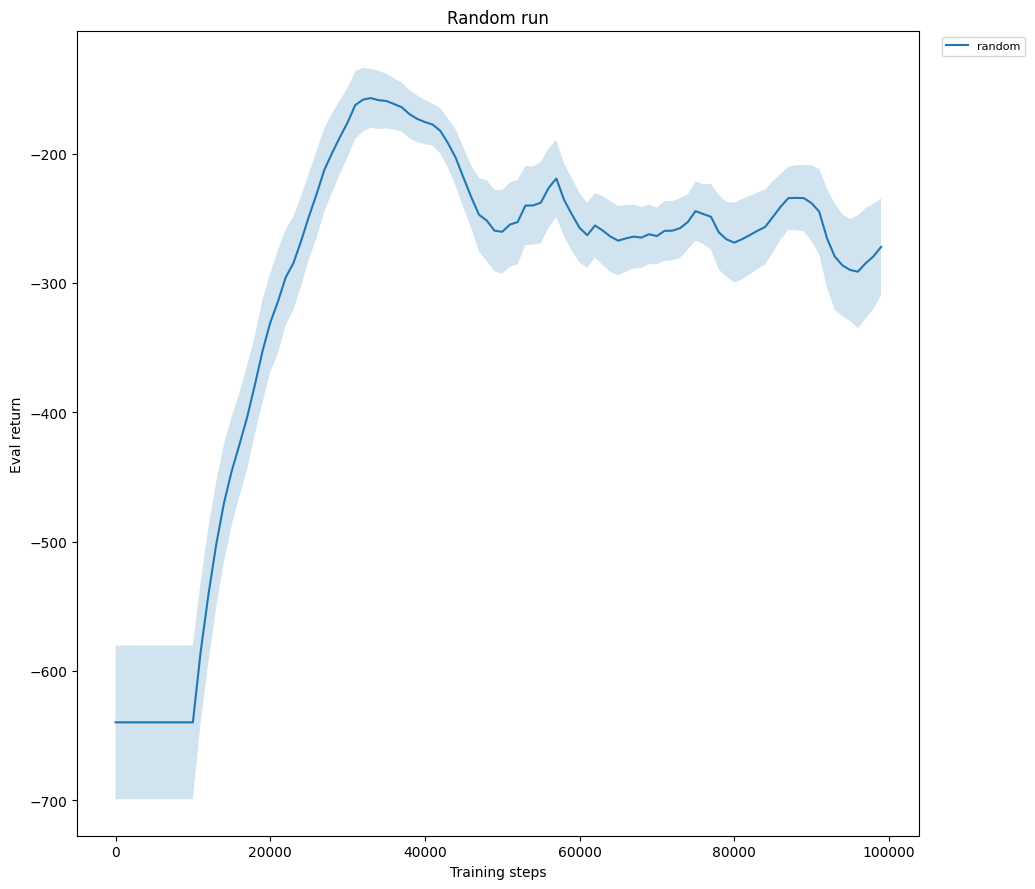

<Figure size 640x480 with 0 Axes>

In [32]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "random" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Random run")


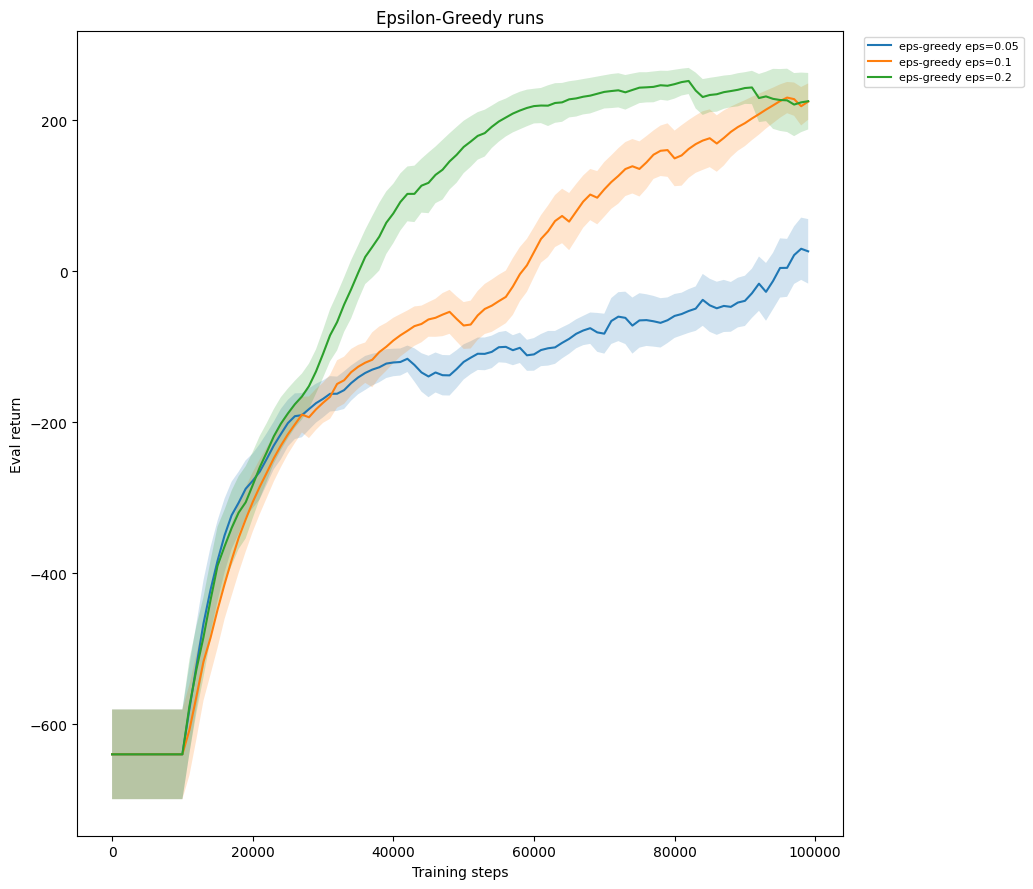

<Figure size 640x480 with 0 Axes>

In [33]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "eps-greedy" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Epsilon-Greedy runs")


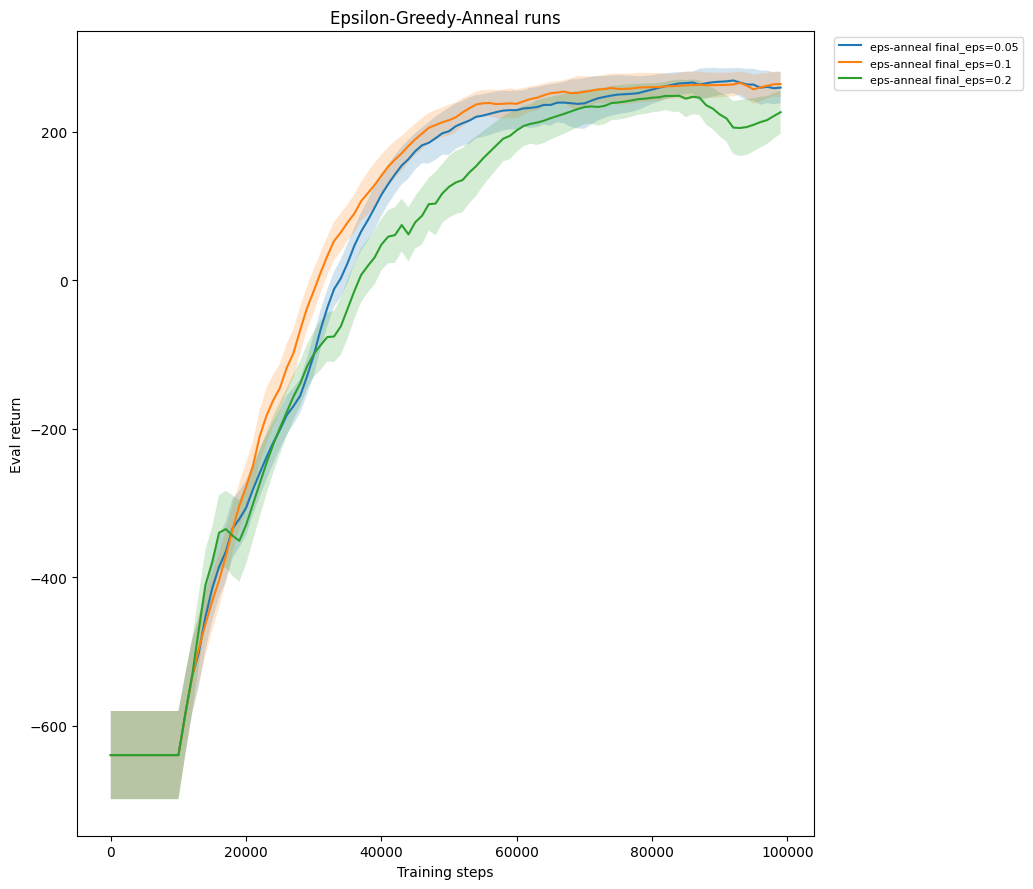

<Figure size 640x480 with 0 Axes>

In [34]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "eps-anneal" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Epsilon-Greedy-Anneal runs")


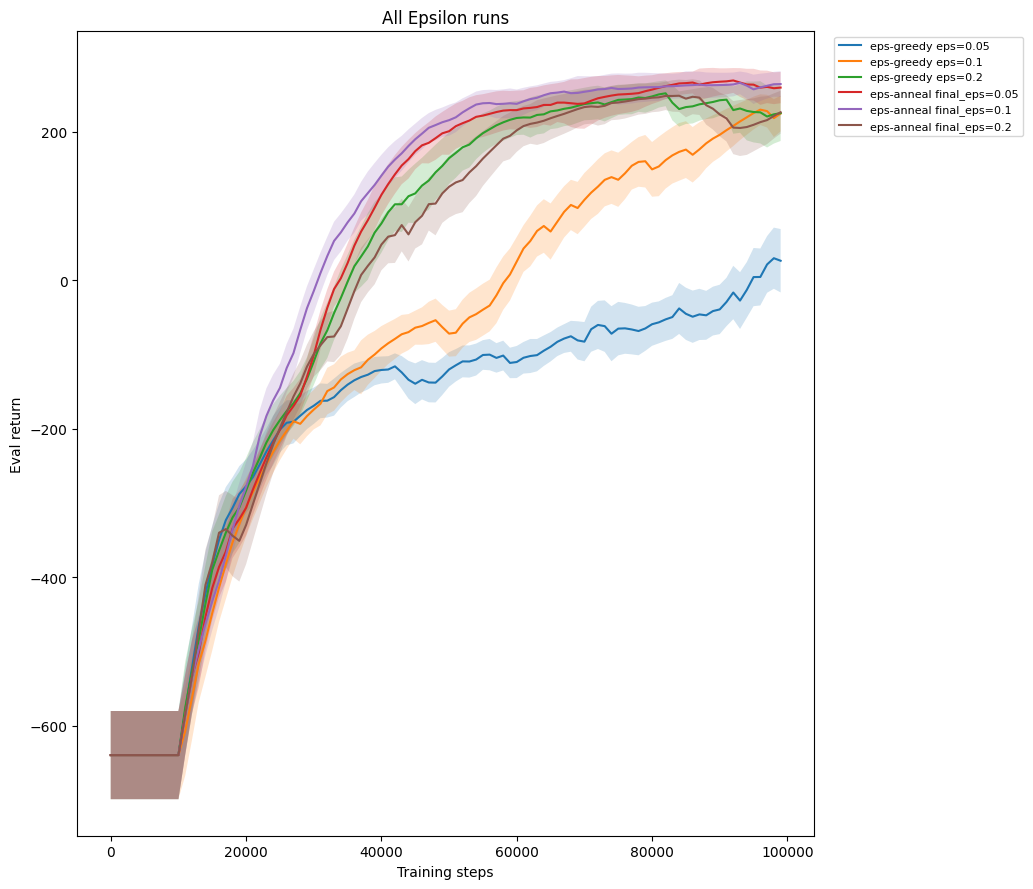

<Figure size 640x480 with 0 Axes>

In [35]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "eps-greedy" in meta.get("run_name", ""):
        dirs.append(r["dir"])
    if "eps-anneal" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="All Epsilon runs")


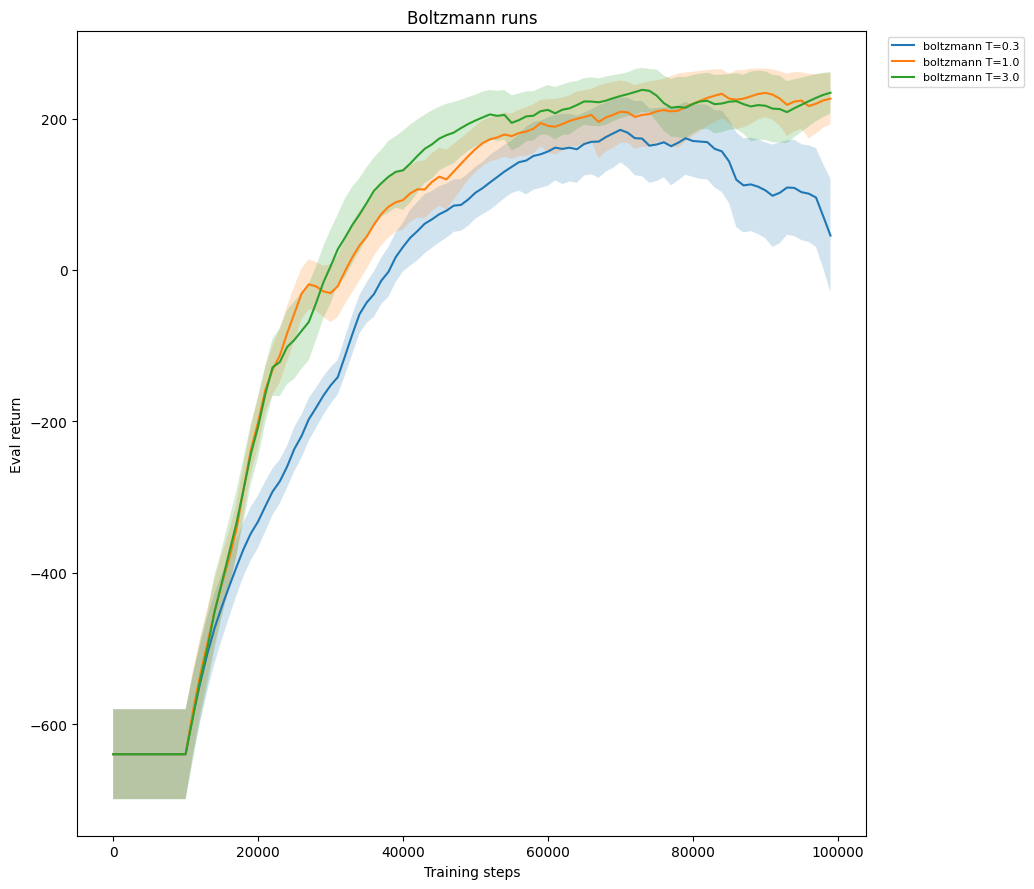

<Figure size 640x480 with 0 Axes>

In [36]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "boltzmann" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Boltzmann runs")


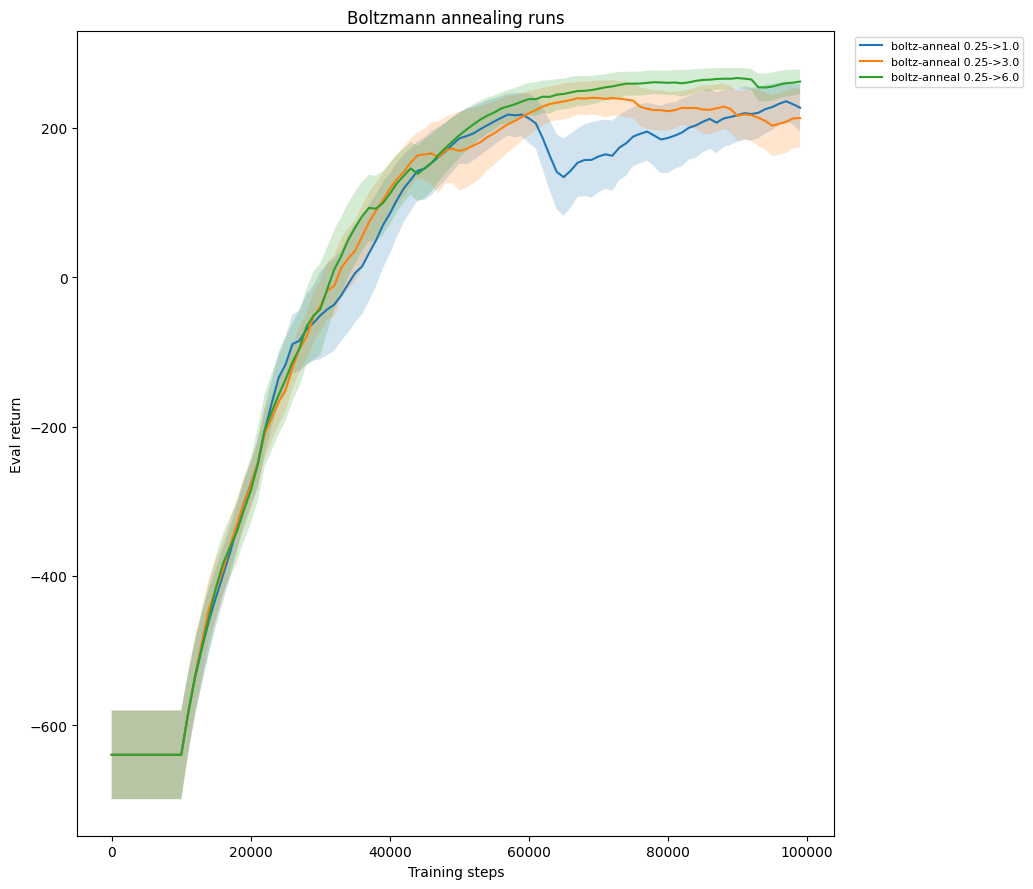

<Figure size 640x480 with 0 Axes>

In [37]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "boltz-anneal" in meta.get("run_name", "") and not "maxboltz-anneal" in meta.get("run_name", "") :
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Boltzmann annealing runs")


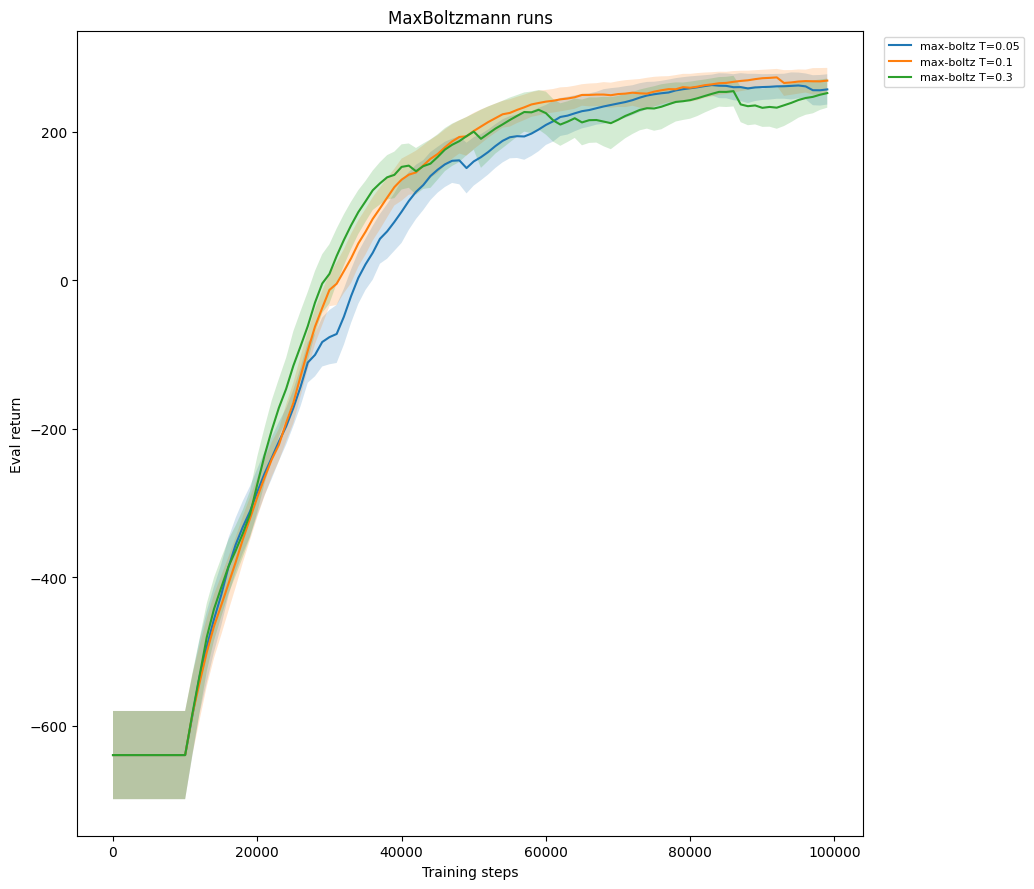

<Figure size 640x480 with 0 Axes>

In [38]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "max-boltz" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="MaxBoltzmann runs")


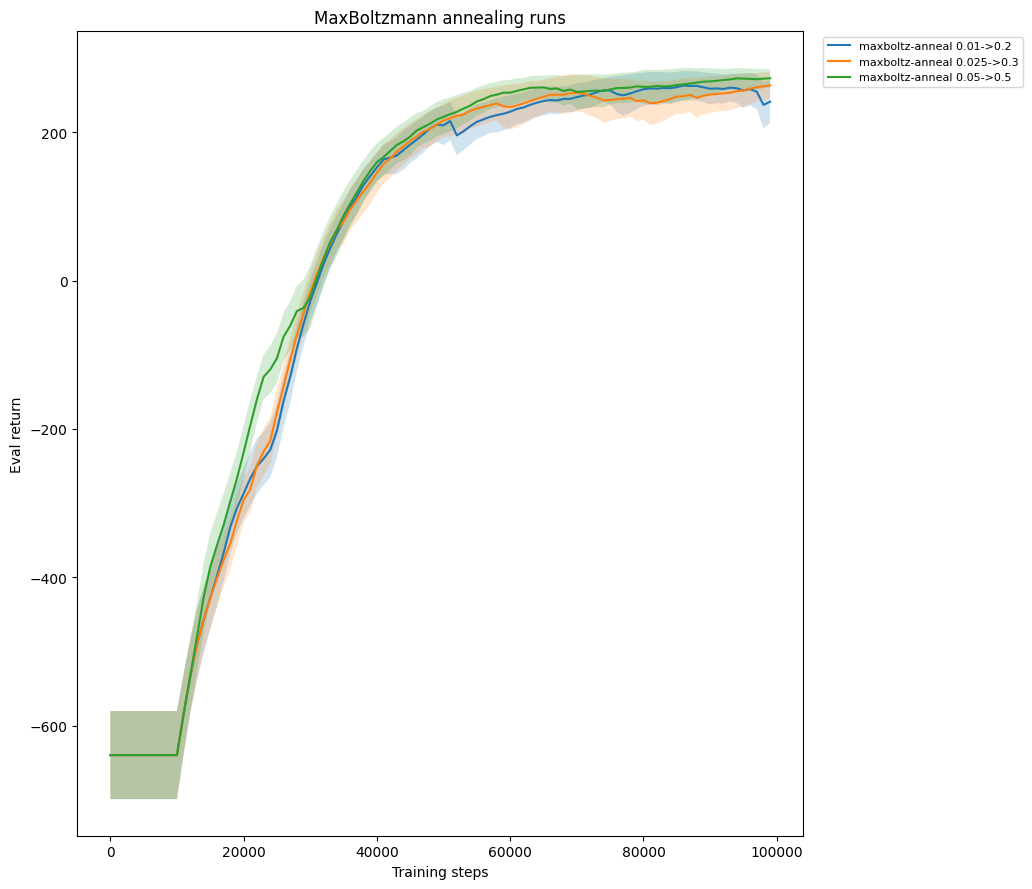

<Figure size 640x480 with 0 Axes>

In [39]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "maxboltz-anneal" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="MaxBoltzmann annealing runs")


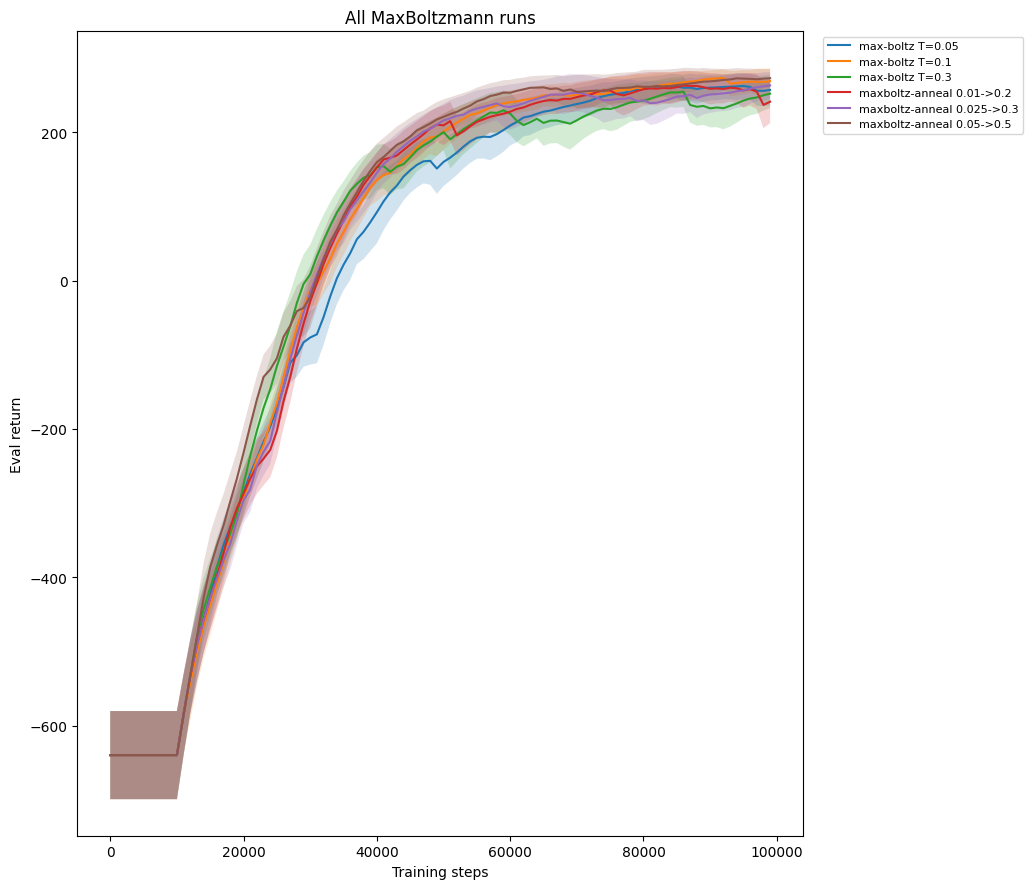

<Figure size 640x480 with 0 Axes>

In [40]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "max-boltz" in meta.get("run_name", ""):
        dirs.append(r["dir"])
    if "maxboltz-anneal" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="All MaxBoltzmann runs")


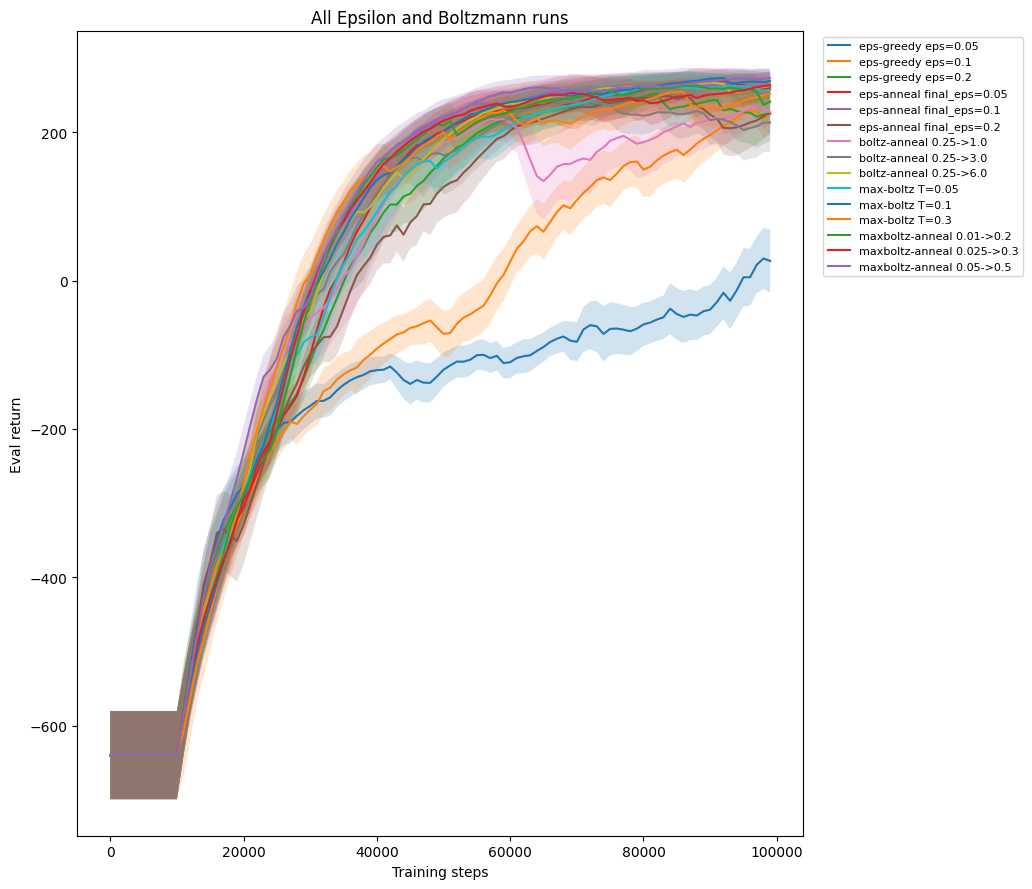

<Figure size 640x480 with 0 Axes>

In [41]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "eps-greedy" in meta.get("run_name", ""):
        dirs.append(r["dir"])
    if "eps-anneal" in meta.get("run_name", ""):
        dirs.append(r["dir"])
    if "max-boltz" in meta.get("run_name", ""):
        dirs.append(r["dir"])
    if "maxboltz-anneal" in meta.get("run_name", ""):
        dirs.append(r["dir"])
    if "boltz-anneal" in meta.get("run_name", "") and not "maxboltz-anneal" in meta.get("run_name", "") :
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="All Epsilon and Boltzmann runs")


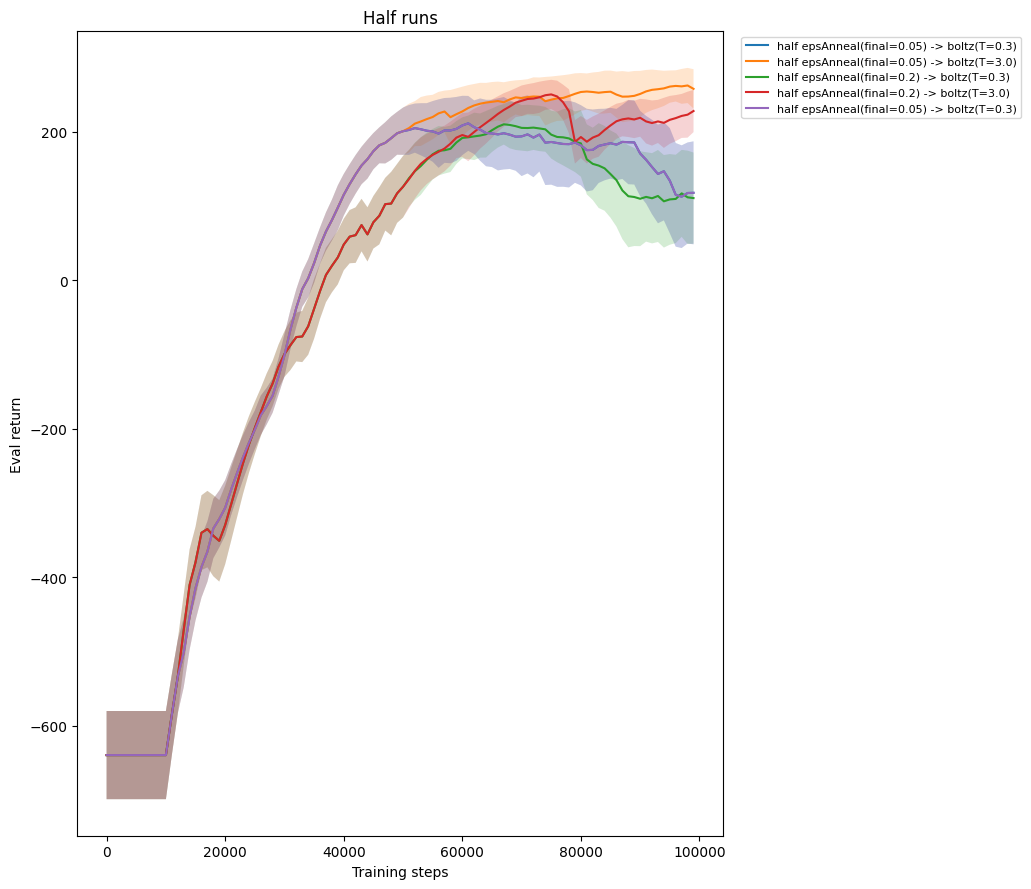

<Figure size 640x480 with 0 Axes>

In [42]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "half" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Half runs")


# Bonus experiments

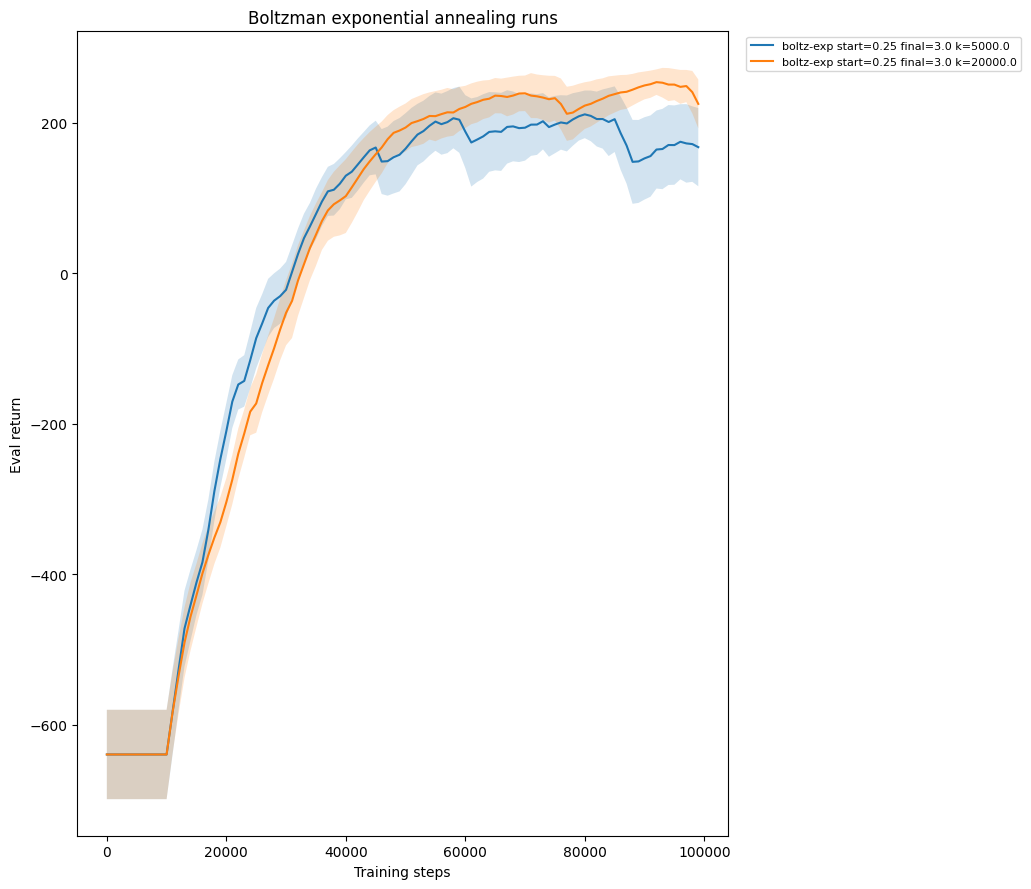

<Figure size 640x480 with 0 Axes>

In [43]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "boltz-exp" in meta.get("run_name", ""):
        dirs.append(r["dir"])


plot_runs(dirs, eval_freq=args.eval_freq, title="Boltzman exponential annealing runs")


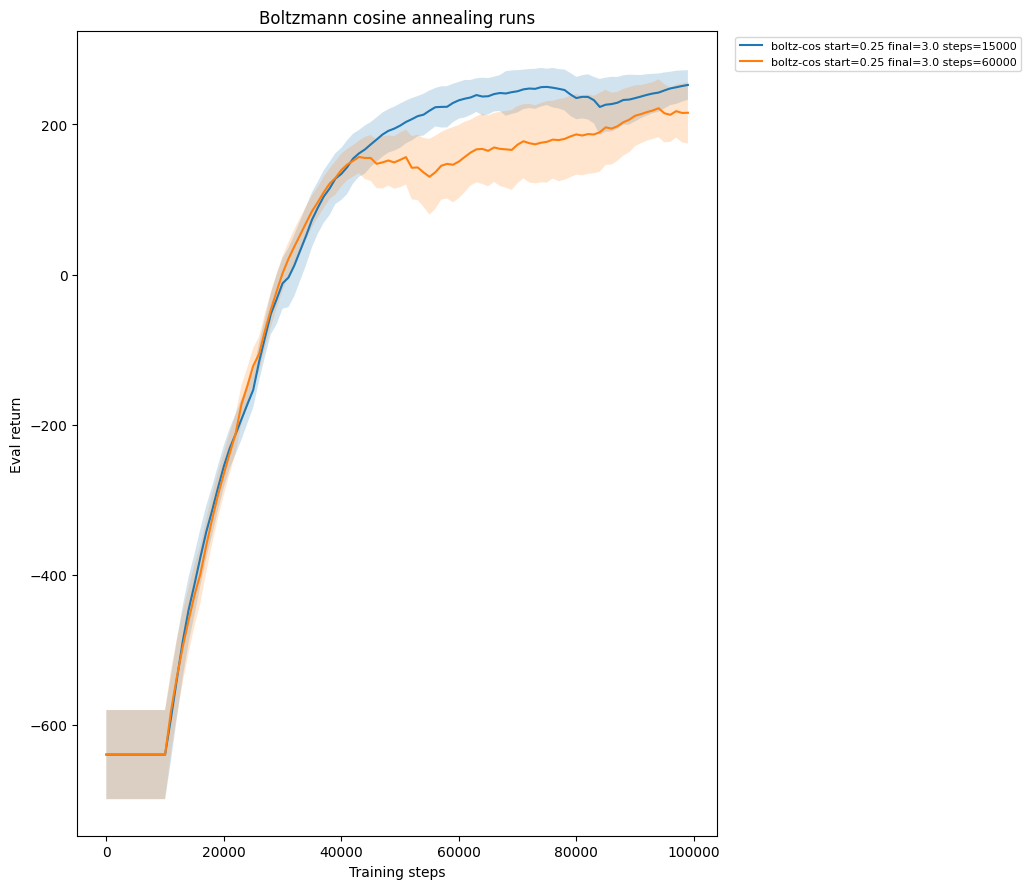

<Figure size 640x480 with 0 Axes>

In [44]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "boltz-cos" in meta.get("run_name", ""):
        dirs.append(r["dir"])


plot_runs(dirs, eval_freq=args.eval_freq, title="Boltzmann cosine annealing runs")


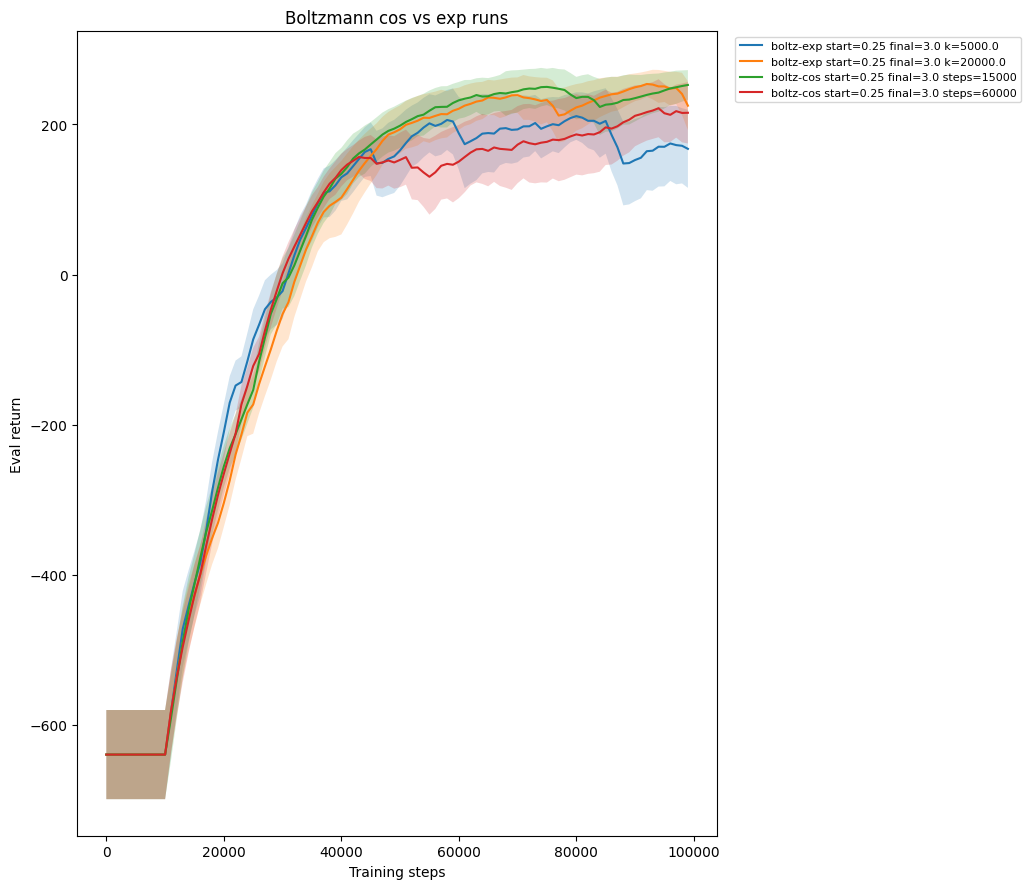

<Figure size 640x480 with 0 Axes>

In [45]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "boltz-cos" in meta.get("run_name", ""):
        dirs.append(r["dir"])

    if "boltz-exp" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Boltzmann cos vs exp runs")


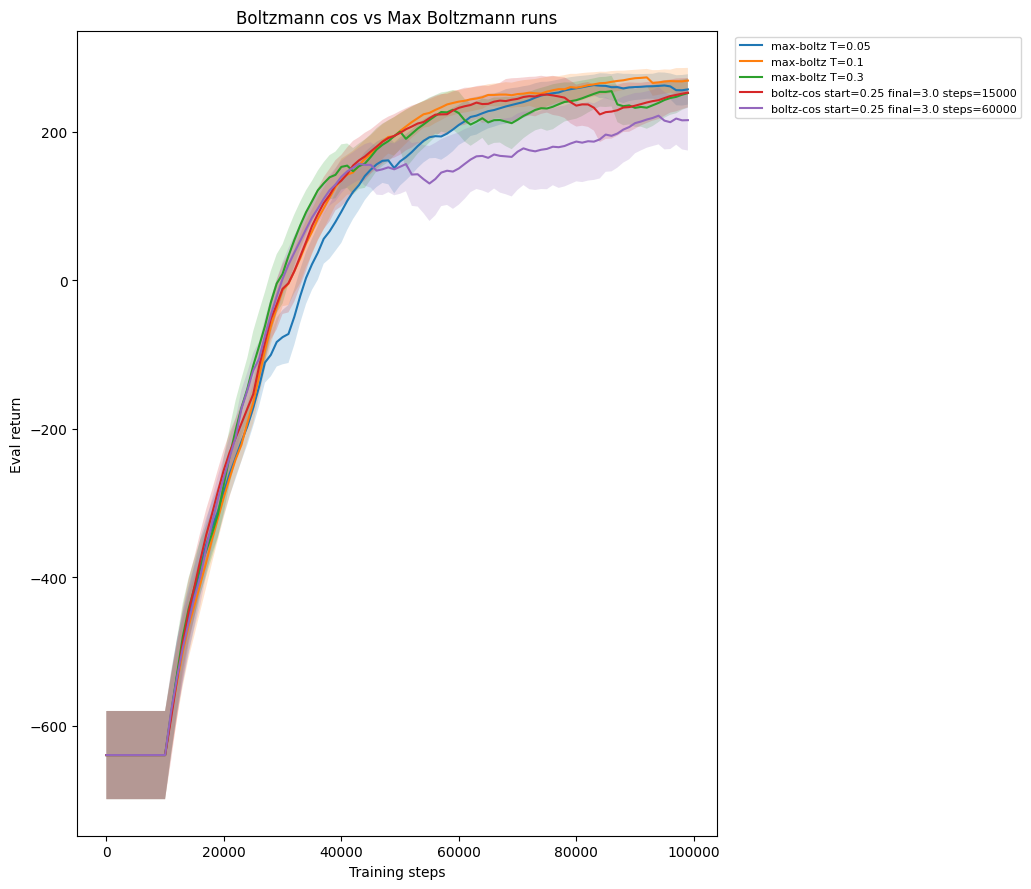

<Figure size 640x480 with 0 Axes>

In [46]:
runs = list_runs("checkpoints")
dirs = []
for r in runs:
    meta = load_meta(r["dir"])
    if "boltz-cos" in meta.get("run_name", ""):
        dirs.append(r["dir"])

    if "max-boltz" in meta.get("run_name", ""):
        dirs.append(r["dir"])

plot_runs(dirs, eval_freq=args.eval_freq, title="Boltzmann cos vs Max Boltzmann runs")


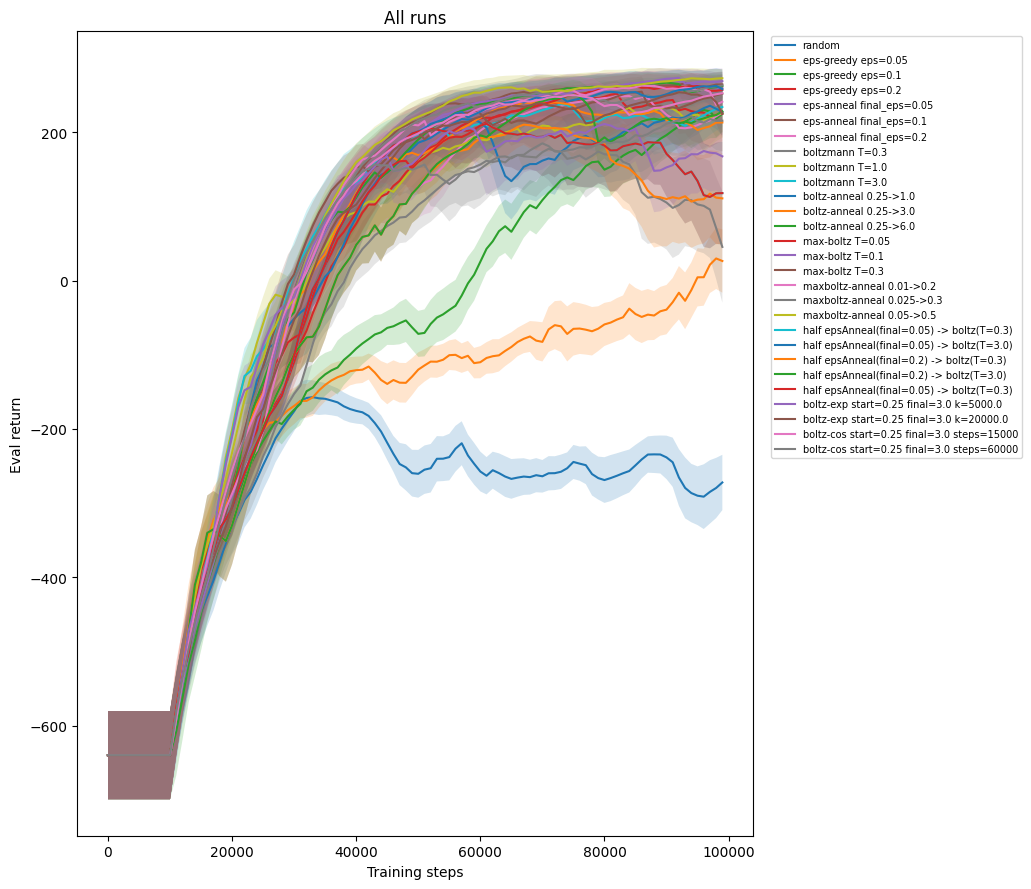

<Figure size 640x480 with 0 Axes>

In [47]:
runs = list_runs("checkpoints")
all_dirs = [r["dir"] for r in runs]
plot_runs(all_dirs, eval_freq=args.eval_freq, title="All runs", legend_fontsize=7)
